In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Import Librairies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import spacy

# SkLearn Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import silhouette_score

# Machine Learning
from sklearn.cluster import KMeans

#Visualize
import matplotlib.pyplot as plt
import seaborn as sns

### Check version

In [ ]:
print('Numpy ' + np.__version__)
print('Spacy ' + spacy.__version__)

### Loading the Dataset

In [ ]:
df = pd.read_csv('../input/movie-imbd-dataset/movie_metadata.csv')

In [ ]:
df.head()

### Data Cleaning

In [ ]:
# Normalize the spelling and add a space between each genre
df['genres'] = df['genres'].str.replace('|', ' ').str.lower()
df['plot_keywords'] = df['plot_keywords'].str.replace('|', ' ').str.lower()

# Replace in the Actor columns NaN by Unkown
df['director_name'] = df['director_name'].fillna('Unknown')
df['actor_1_name'] = df['actor_1_name'].fillna('Unknown')
df['actor_2_name'] = df['actor_2_name'].fillna('Unknown')
df['actor_3_name'] = df['actor_3_name'].fillna('Unknown')

# Clean the Color column
df['color'] = df['color'].fillna('Color')

# Clean the title column
df['movie_title'] = df['movie_title'].str.replace('\xa0','')

# Drop some columns
df = df.drop(['movie_imdb_link'], axis=1)

In [ ]:
df['movie_title']

In [ ]:
# Encode the Color column in a numeric form
lab_enc = LabelEncoder()
df['color'] = lab_enc.fit_transform(df['color'])

### Creation of a DataFrame with all the numeric features

In [ ]:
df_num = df.select_dtypes(include=np.number)
df_num.head()

### Let's do some Preprocessing on this DataFrame

In [ ]:
# Scale
scaler = MinMaxScaler()
scaler.fit(df_num)

# Apply
df_num_scaled = scaler.transform(df_num)
df_num_scaled = pd.DataFrame(df_num_scaled)
df_num_scaled.head()

In [ ]:
# Distribution Graph on the 16 numerical columns
for column in df_num_scaled.columns:
    df_num_scaled[column].hist()
    plt.title(column)
    plt.show()

### Let's now look at the correlation between the numeric features

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Data scaled using MinMax Scaler')
sns.heatmap(df_num_scaled.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 120, n=200))

plt.show()

**We note a few features that doesn't correlate well with the rest :**
* 0
* 9
* 11
* 15

We are going to drop them

In [ ]:
df_num_scaled = df_num_scaled.drop(columns=[0, 9, 11, 15])

plt.figure(figsize=(16,9))
plt.title('Data scaled using MinMax Scaler')
sns.heatmap(df_num_scaled.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 120, n=200))

plt.show()

We can leave our numeric features for now, and move to the Second Part :

## Use Spacy to create a Recommendation Engine
### First, create a new DataFrame

In [ ]:
df_nlp = df.filter(['movie_title', 'genres', 'director_name', 'plot_keywords', 'content_rating'], axis=1)
df_nlp.head()

In [ ]:
df_nlp.info()

Let's clean a little the plot_keywords and content_rating columns :

In [ ]:
df_nlp['plot_keywords'] = df_nlp['plot_keywords'].fillna('Unknown').str.lower()
df_nlp['content_rating'] = df_nlp['content_rating'].fillna('Unknown')
df_nlp.info()

In [ ]:
# Creation of an index column
#df_nlp.insert(0, 'id', range(0, len(df_nlp)))
#df_nlp.head()

### Let's create some Soups! Bag of Words in different versions to compare our Engines

In [ ]:
df_nlp['soup1'] = df_nlp['movie_title'] + ' ' + df_nlp['genres']
df_nlp['soup2'] = df_nlp['movie_title'] + ' ' + df_nlp['genres'] + ' ' + df_nlp['director_name']
df_nlp['soup3'] = df_nlp['movie_title'] + ' ' + df_nlp['genres'] + ' ' + df_nlp['director_name'] + ' ' + df_nlp['plot_keywords']
df_nlp['soup4'] = df_nlp['movie_title'] + ' ' + df_nlp['genres'] + ' ' + df_nlp['director_name'] + ' ' + df_nlp['plot_keywords'] + ' ' + df_nlp['content_rating']
df_nlp['soup5'] = df_nlp['movie_title'] + ' ' + df_nlp['genres'] + ' ' + df_nlp['plot_keywords']
df_nlp['soup6'] = df_nlp['movie_title'] + ' ' + df_nlp['genres'] + ' ' + df_nlp['content_rating']

In [ ]:
df_nlp.head()

### Vectorization

In [ ]:
# Initialiser le TfidfVectorizer en enlevant les stop_wordds
tfidf = TfidfVectorizer(stop_words='english')

# constuire the TF-IDF matrix
tfidf_matrix1 = tfidf.fit_transform(df_nlp['soup1'])
tfidf_matrix2 = tfidf.fit_transform(df_nlp['soup2'])
tfidf_matrix3 = tfidf.fit_transform(df_nlp['soup3'])
tfidf_matrix4 = tfidf.fit_transform(df_nlp['soup4'])
tfidf_matrix5 = tfidf.fit_transform(df_nlp['soup5'])
tfidf_matrix6 = tfidf.fit_transform(df_nlp['soup6'])

print('tfidf1 shape: {}'.format(tfidf_matrix1.shape))
print('tfidf2 shape: {}'.format(tfidf_matrix2.shape))
print('tfidf3 shape: {}'.format(tfidf_matrix3.shape))
print('tfidf4 shape: {}'.format(tfidf_matrix4.shape))
print('tfidf5 shape: {}'.format(tfidf_matrix5.shape))
print('tfidf6 shape: {}'.format(tfidf_matrix6.shape))

In [ ]:
# Compute the cosine similarity matrix
cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)
cosine_sim3 = linear_kernel(tfidf_matrix3, tfidf_matrix3)
cosine_sim4 = linear_kernel(tfidf_matrix4, tfidf_matrix4)
cosine_sim5 = linear_kernel(tfidf_matrix5, tfidf_matrix5)
cosine_sim6 = linear_kernel(tfidf_matrix6, tfidf_matrix6)

cosine_sim1.shape

In [ ]:
indices = pd.Series(df_nlp.index, index=df_nlp['movie_title']).drop_duplicates()

def get_recommendations(title, cosine_sim, indices=indices):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_nlp['movie_title'].iloc[movie_indices]

In [ ]:
get_recommendations('Frozen', cosine_sim1)

In [ ]:
get_recommendations('Frozen', cosine_sim2)

In [ ]:
get_recommendations('Frozen', cosine_sim4)

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim1)

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim3)

* I am no expert in movie, but it looks like, especially with the example Frozen, that the usage of plot_keywords doesn't help.
* If we choose one engine, I would should the number 1 or 2.
* Let's take the number 2 to recommend movies for Marine

---
### Recommendation for Marine
* She would like to get a recommendation for:
    * RocknRolla
    * Inception
    * Hitch
    * Sherlock Holmes
    * Coco

In [ ]:
get_recommendations('RocknRolla', cosine_sim2)

In [ ]:
get_recommendations('Inception', cosine_sim2)

In [ ]:
get_recommendations('Hitch', cosine_sim2)

In [ ]:
get_recommendations('Sherlock Holmes', cosine_sim2)

---
## Let's now try to implement something using K-means

* Go back to use df_num_scaled
* Join tfidf_matrix2 to it:
    * Because the results weren't so bad
    * And because the shape of the matrix is smaller than other, to reduce the calculation time

In [ ]:
tfidf_matrix2

In [ ]:
df_tfidf = pd.DataFrame(tfidf_matrix2)

In [ ]:
df_cos = pd.DataFrame(cosine_sim2)
df_cos.head()

In [ ]:
df_new = pd.concat([df_num_scaled, df_cos], axis=1)

In [ ]:
df_new.shape

In [ ]:
df.info()

In [ ]:
df_new = df_new.dropna()
df_new.info()

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_new) for k in range(1, 20)] # I'm running 300
#  méthode du coude avec le silhouette_score
silhouette_scores = [silhouette_score(df_new, kmeans.labels_) for kmeans in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(range(2, 20), silhouette_scores, 'o-')
plt.title("df_new")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.show()

### Let's train a model

In [ ]:
model = KMeans(n_clusters=7, init='k-means++', random_state=42)
y_pred = model.fit_predict(df_new)

In [ ]:
# Show the size of each cluster
pd.Series(model.labels_).value_counts()

* We now have what we could call regular clusters.
* One way we could recommend a movie would be to go in one cluster and look at the similarities with other close movies to the one that we need to recommend

---
## Visualization

In this last part of the notebook, I will look through the Dataset using graphs and Power BI

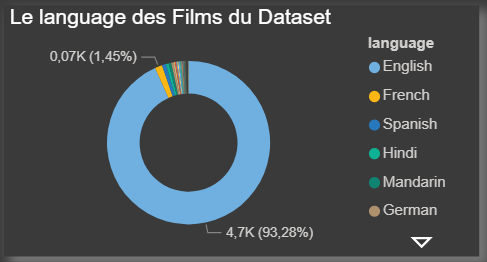

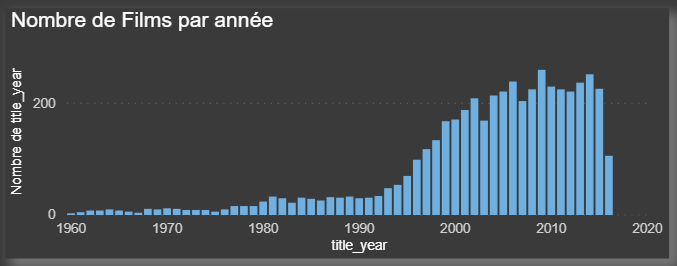

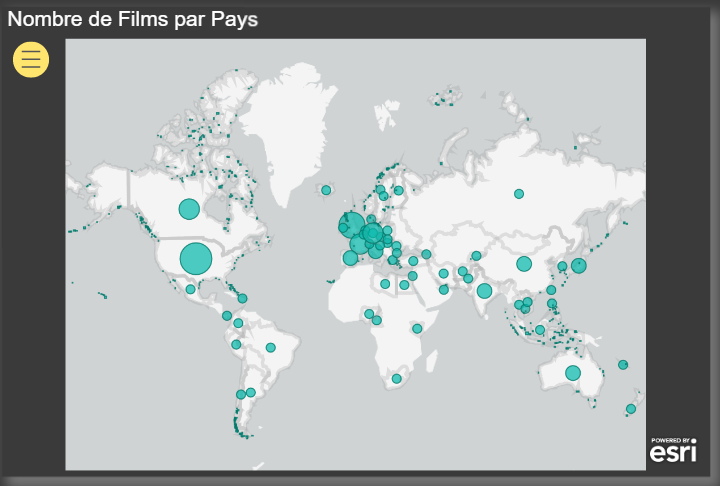

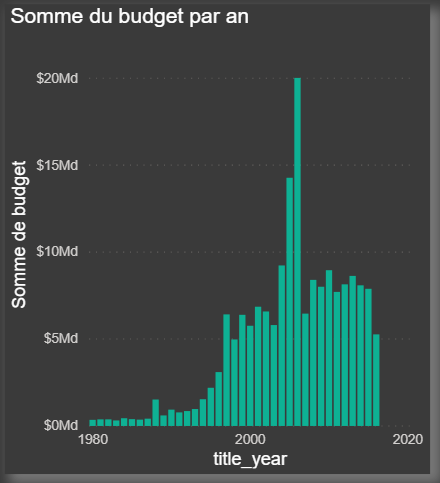

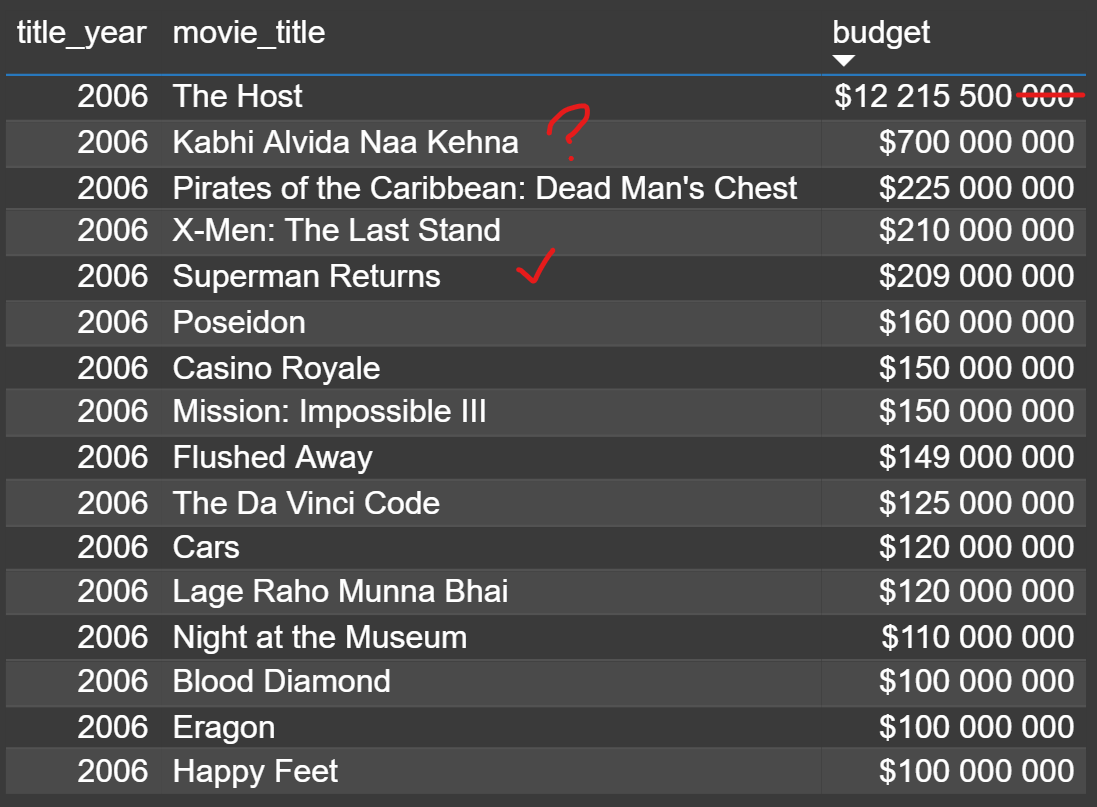

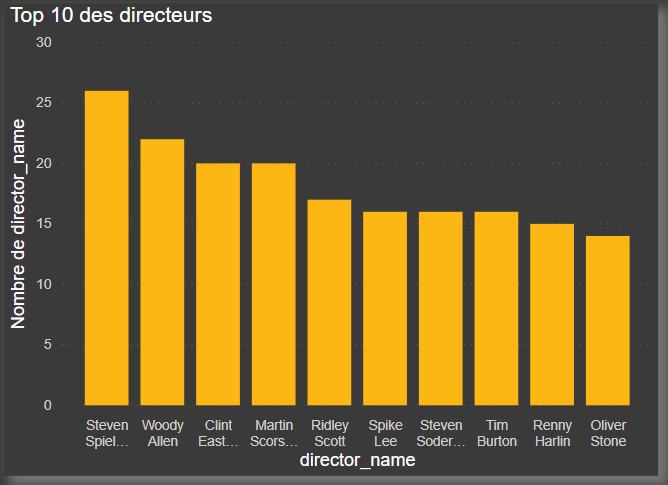

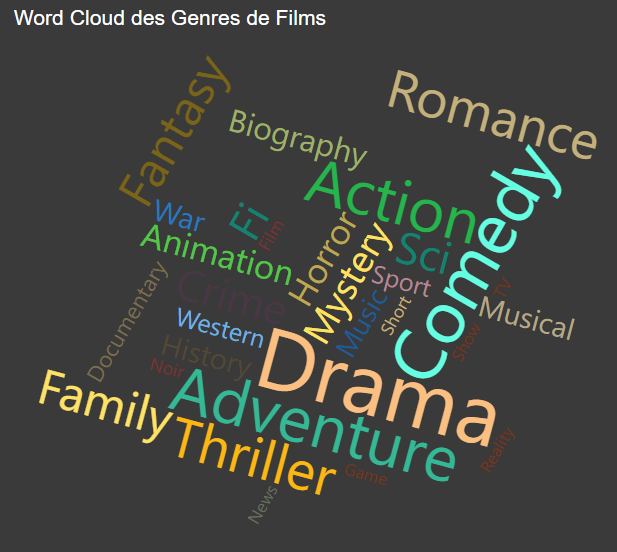

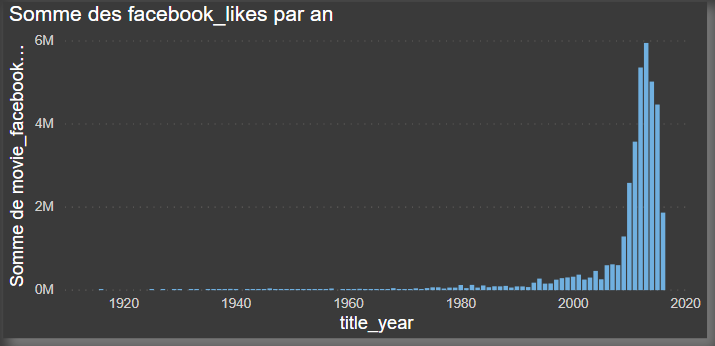

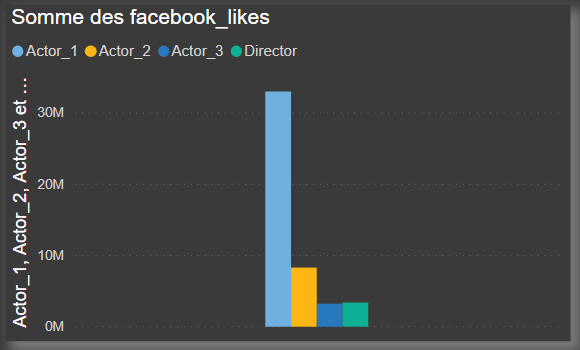

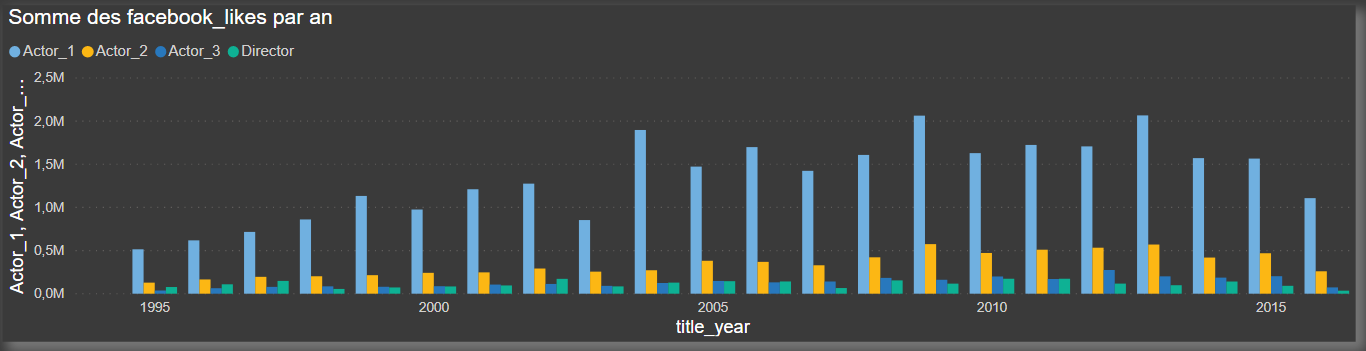